In [374]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from samplics.estimation import TaylorEstimator
from samplics.utils.types import PopParam
from datetime import datetime
import matplotlib.colors as mcolors
import math
dir='C:\\Users\\juank\\Documents\\Pruebas\\ATENEA'
os.chdir(dir)

sns.set_theme(style='white')
sns.set_context("notebook")

import warnings
warnings.filterwarnings('ignore')

# 2. Encuesta multiproposito 2021.

### a. Identificador

In [375]:
id=pd.read_csv('.\\multi\\Identificación (Capítulo A).csv',encoding='latin-1',sep=';')
id.drop(columns='FEX_C',inplace=True)

### b. Condiciones de la vivienda

In [376]:
cond_v=pd.read_csv('.\\multi\\Condiciones habitacionales del hogar (Capítulo C).csv',encoding='latin-1',sep=';')
cond_v=cond_v[['DIRECTORIO', 'DIRECTORIO_HOG', 'SECUENCIA_P', 'NHCCP1','NHCCP11','NHCCPCTRL2','NHCCP29','NHCCP29A','NHCCP31','FEX_C']]
cond_v['FEX_C']=cond_v.FEX_C.astype('str').str.replace(',','.').astype('float')

Union de las bases.

In [377]:
multi=cond_v.merge(id,how='right',right_on='DIRECTORIO',left_on='DIRECTORIO')

### c. Datos de vivienda

In [378]:
vivi=pd.read_csv('.\\multi\\Datos de la vivenda y su entorno (Capítulo B).csv',encoding='latin-1',sep=';')[['DIRECTORIO', 'NVCBP10','NVCBP11A',
                                                                                                             'NVCBP11AA', 'NVCBP11B', 'NVCBP11C','NVCBP11D']]

Union de las bases.

In [379]:
multi=multi.merge(vivi,how='right',right_on='DIRECTORIO',left_on='DIRECTORIO')

### d. Demografia

In [380]:
demo=pd.read_csv('.\\multi\\Composición del hogar y demografía (Capítulo E).csv',encoding='latin-1',sep=';')[['DIRECTORIO', 'DIRECTORIO_HOG', 'DIRECTORIO_PER', 'SECUENCIA_P','ORDEN', 'NPCEP4', 'NPCEP_5', 'NPCEP5', 'SEXO', 'NPCEP6', 'NPCEP7',
'NPCEP11A', 'NPCEP11AA', 'NPCEP11AB', 'NPCEP11D','NPCEP11','NPCEP17','NPCEP22', 'NPCEP22A','NPCEP25', 'NPCEP25A', 'NPCEP27', 'NPCEP26', 'NPCEP29',
'NPCEP29A']]

Union de las bases.

In [381]:
multi=demo.merge(multi,how='right',right_on=['DIRECTORIO', 'DIRECTORIO_HOG'],left_on=['DIRECTORIO', 'DIRECTORIO_HOG'])

### e. Fuerza laboral

In [382]:
Fuerza=pd.read_csv('.\\multi\\Fuerza de trabajo (Capítulo K).csv',encoding='latin-1',sep=';')[['DIRECTORIO', 'DIRECTORIO_HOG', 'DIRECTORIO_PER', 'SECUENCIA_P','ORDEN','NPCKP1', 'NPCKP2', 'NPCKP3', 'NPCKP4','NPCKP8', 'NPCKP10', 'NPCKP11',
'NPCKP13', 'NPCKP17', 'NPCKP18','NPCKP19', 'NPCKP20', 'NPCKP20A','NPCKP23','NPCKP24', 'NPCKP24A', 'NPCKP24B', 'NPCKP25', 'NPCKP25A','NPCKP26', 
'NPCKP26A', 'NPCKP27', 'NPCKP27A','NPCKP36','NPCKP44','NPCKP47A','NPCKP48A', 'NPCKP50_A', 'NPCKP50_B',
'NPCKP52A','NPCKP59AA','NPCKP59BA', 'NPCKP59CA', 'NPCKP59DA', 'NPCKP59EA','NPCKP59FA', 'NPCKP59GA',  'NPCKP59HA','PET', 'OCU', 'DES', 'FL', 
'FFL', 'PET_DEFA', 'OCU_DEFA','DES_DEFA', 'INI_DEFA', 'PEA_DEFA', 'OINFORMAL']]

**Salario** 

In [383]:
for i in ['NPCKP23','NPCKP24', 'NPCKP24A', 'NPCKP24B', 'NPCKP25', 'NPCKP25A','NPCKP26', 
'NPCKP26A', 'NPCKP27', 'NPCKP27A','NPCKP36','NPCKP47A','NPCKP48A','NPCKP52A']:
    Fuerza[i]=Fuerza[i].fillna(0)

1. ingreso proveniente de horas extras que no se contaron en el salario

In [384]:
he=[]
for i in Fuerza.NPCKP24B:
    if i == 2:
        he.append(1)
    else:
        he.append(0)
Fuerza['NPCKP24B']=he
Fuerza['HE']=Fuerza.NPCKP24B*Fuerza.NPCKP24A

2. Salario en especie, en alimentos y en vivienda

In [385]:
Fuerza['OW']=Fuerza.NPCKP25A+Fuerza.NPCKP26A+Fuerza.NPCKP27A

3. Salario total

In [386]:
Fuerza['W']=Fuerza.NPCKP23+Fuerza.HE+Fuerza.OW

Otros ingresos

In [387]:
Fuerza['Y']=(Fuerza.NPCKP36+Fuerza.NPCKP47A)+Fuerza.NPCKP48A 

**Pensiones**

In [388]:
Fuerza['Pensiones']=Fuerza.NPCKP52A

Se borra las variables de salario, ingresos y pesnsiones

In [389]:
Fuerza.drop(columns=['NPCKP23','NPCKP24', 'NPCKP24A', 'NPCKP24B', 'NPCKP25', 'NPCKP25A','NPCKP26', 
'NPCKP26A', 'NPCKP27', 'NPCKP27A','NPCKP36','NPCKP47A','NPCKP48A','NPCKP52A'],inplace=True)

**Horas de cuidado**

In [390]:
Fuerza['Cuidado']=Fuerza[['NPCKP59AA','NPCKP59BA', 'NPCKP59CA', 'NPCKP59DA', 'NPCKP59EA','NPCKP59FA', 'NPCKP59GA','NPCKP59HA']].sum(axis=1)
Fuerza.drop(columns=['NPCKP59AA','NPCKP59BA', 'NPCKP59CA', 'NPCKP59DA', 'NPCKP59EA','NPCKP59FA', 'NPCKP59GA','NPCKP59HA'],inplace=True)

**Experiencia laboral**

In [391]:
Fuerza['NPCKP50_B']=Fuerza.NPCKP50_B/12

In [392]:
Fuerza['Experiencia']=Fuerza[[ 'NPCKP50_A', 'NPCKP50_B']].fillna(0).sum(axis=1)
Fuerza.drop(columns=[ 'NPCKP50_A', 'NPCKP50_B'],inplace=True)

Union de las bases.

In [393]:
multi=Fuerza.merge(multi,how='right',right_on=['DIRECTORIO', 'DIRECTORIO_HOG','DIRECTORIO_PER'],left_on=['DIRECTORIO', 'DIRECTORIO_HOG','DIRECTORIO_PER'])

### F. Educación

In [394]:
Educ=pd.read_csv('.\\multi\\Educación (Capitulo H).csv',encoding='latin-1',sep=';')[['DIRECTORIO', 'DIRECTORIO_HOG', 'DIRECTORIO_PER', 'NPCHP1', 'NPCHP2', 'NPCHP3', 'NPCHP4', 'NPCHP4A',
'NPCHP5', 'NPCHP6', 'NPCHP6A', 'NPCHP7', 'NPCHP9A','NPCHP9B', 'NPCHP9C', 'NPCHP9D', 'NPCHP9E','NPCHP10A','NPCHP11A','NPCHP12', 'NPCHP12A',
'NPCHP13B','NPCHP14', 'NPCHP16','NPCHP17','NPCHP20', 'NPCHP21AA', 'NPCHP21BA', 'NPCHP21CA', 'NPCHP21DA','NPCHP22A',
'NPCHP23A','NPCHP24', 'NPCHP24AA','NPCHP24BA','NPCHP28', 'NPCHP28A','NPCHP32', 'NPCHP32B', 'NPCHP32A','NPCHP36']]

**Subsidios**

In [395]:
Educ['Subsidios']=Educ[['NPCHP9A','NPCHP9B', 'NPCHP9C', 'NPCHP9D', 'NPCHP9E']].fillna(0).replace(2,0).sum(axis=1)
Educ.drop(columns=['NPCHP9A','NPCHP9B', 'NPCHP9C', 'NPCHP9D', 'NPCHP9E'],inplace=True)

**Valor de la matricula y transporte**

In [396]:
Educ['Valor_matricula']=Educ[['NPCHP10A','NPCHP11A']].fillna(0).sum(axis=1)
Educ.drop(columns=['NPCHP10A','NPCHP11A'],inplace=True)

**Valor beca**

In [397]:
Educ['Varlor_beca']=Educ[['NPCHP24AA','NPCHP24BA']].fillna(0).sum(axis=1).sum()
Educ.drop(columns=['NPCHP24AA','NPCHP24BA'],inplace=True)

### g. Base final

In [398]:
multi=Educ.merge(multi,how='right',right_on=['DIRECTORIO', 'DIRECTORIO_HOG','DIRECTORIO_PER'],left_on=['DIRECTORIO', 'DIRECTORIO_HOG','DIRECTORIO_PER'])
multi.drop(columns=['SECUENCIA_P_x','SECUENCIA_P_y','ORDEN_y','ORDEN_x'],inplace=True)

#  2.1. Analisis de logro académico

Total de personas

In [399]:
n=multi.FEX_C.sum()

**1. Analfabetismo**

In [400]:
print(f"{round((multi[multi['NPCHP1']==2].FEX_C.sum()/multi[multi['NPCEP4']>=5].FEX_C.sum())*100,1)}% de la población mayor de 5 años es analfabeta")

2.1% de la población mayor de 5 años es analfabeta


In [401]:
print(f"El {round((multi[(multi['SEXO']==2)&(multi['NPCHP1']==2)].FEX_C.sum()/multi[multi['NPCHP1']==2].FEX_C.sum())*100,1)}% de los analfabetas son mujeres y el {100-round((multi[(multi['SEXO']==2)&(multi['NPCHP1']==2)].FEX_C.sum()/multi[multi['NPCHP1']==2].FEX_C.sum())*100,1)}% son hombres")

El 51.3% de los analfabetas son mujeres y el 48.7% son hombres


In [407]:
5*(multi[(multi['SEXO']==1)&(multi['NPCHP1']==2)].FEX_C.sum()/multi[(multi['SEXO']==2)&(multi['NPCHP1']==2)].FEX_C.sum())

4.74083515374479

In [408]:
print(f"Por cada 5 mujeres hay {round(5*(multi[(multi['SEXO']==1)&(multi['NPCHP1']==2)].FEX_C.sum()/multi[(multi['SEXO']==2)&(multi['NPCHP1']==2)].FEX_C.sum()))}")

Por cada 5 mujeres hay 5


In [409]:
print(f"{round((multi[(multi['NPCHP1']==2)&(multi['NPCEP4']>=5)&(multi['NPCEP4']<18)].FEX_C.sum()/multi[(multi['NPCEP4']>=5)&(multi['NPCEP4']<18)].FEX_C.sum())*100,1)}% de la población mayor de 5 años  y menor de 18 años es analfabeta")

6.7% de la población mayor de 5 años  y menor de 18 años es analfabeta


In [410]:
print(f"{round((multi[(multi['NPCHP1']==2)&(multi['NPCEP4']>=5)&(multi['NPCEP4']<18)].FEX_C.sum()/multi[(multi['NPCHP1']==2)&(multi['NPCEP4']>=5)].FEX_C.sum())*100,1)}% de la población analfabeta es menor de edad]")

59.7% de la población analfabeta es menor de edad]


In [411]:
print(f"{round((multi[(multi['NPCHP1']==2)&(multi['NPCEP4']>=18)].FEX_C.sum()/multi[(multi['NPCEP4']>=18)].FEX_C.sum())*100,1)}% de la población mayor de edad es analfabeta")

1.1% de la población mayor de edad es analfabeta


**Rango de edades**

In [412]:
edad=[f'{i}+' if i ==80 else f'{i}-{i+4}' for i in [0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80]]

In [413]:
multi['edad']=pd.cut(multi['NPCEP4'],bins=[0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,np.inf],right=False,
       labels=edad)

In [414]:
rango=[i for i in multi.edad]
multi['edad']=rango
etiq={}
n=1
for i in edad:
    etiq[i]=n
    n+=1
# multi['rango_e'].replace(etiq,inplace=True)

Etiqueta a sexo

In [415]:
multi.SEXO.replace({1:'Hombre',2:'Mujer'},inplace=True)

**2. Nivel acádemico alcanzado por edad**

ultimo año alcanzado

In [416]:
grado={1:'Ninguno',2: 'Preescolar',3: 'Primaria',4: 'Bachillerato',5: 'Bachillerato',6: 'Técnico - Tecnológico',7: 'Técnico - Tecnológico',
8: 'Pregrado',9: 'Pregrado',10: 'Posgrado',11: 'Posgrado',12: 'Posgrado',13: 'Posgrado',14: 'Posgrado',15: 'Posgrado'}

In [417]:
multi['ultimo_grado']=multi['NPCHP4'].replace(grado)

Gráfica: piramide poblacional

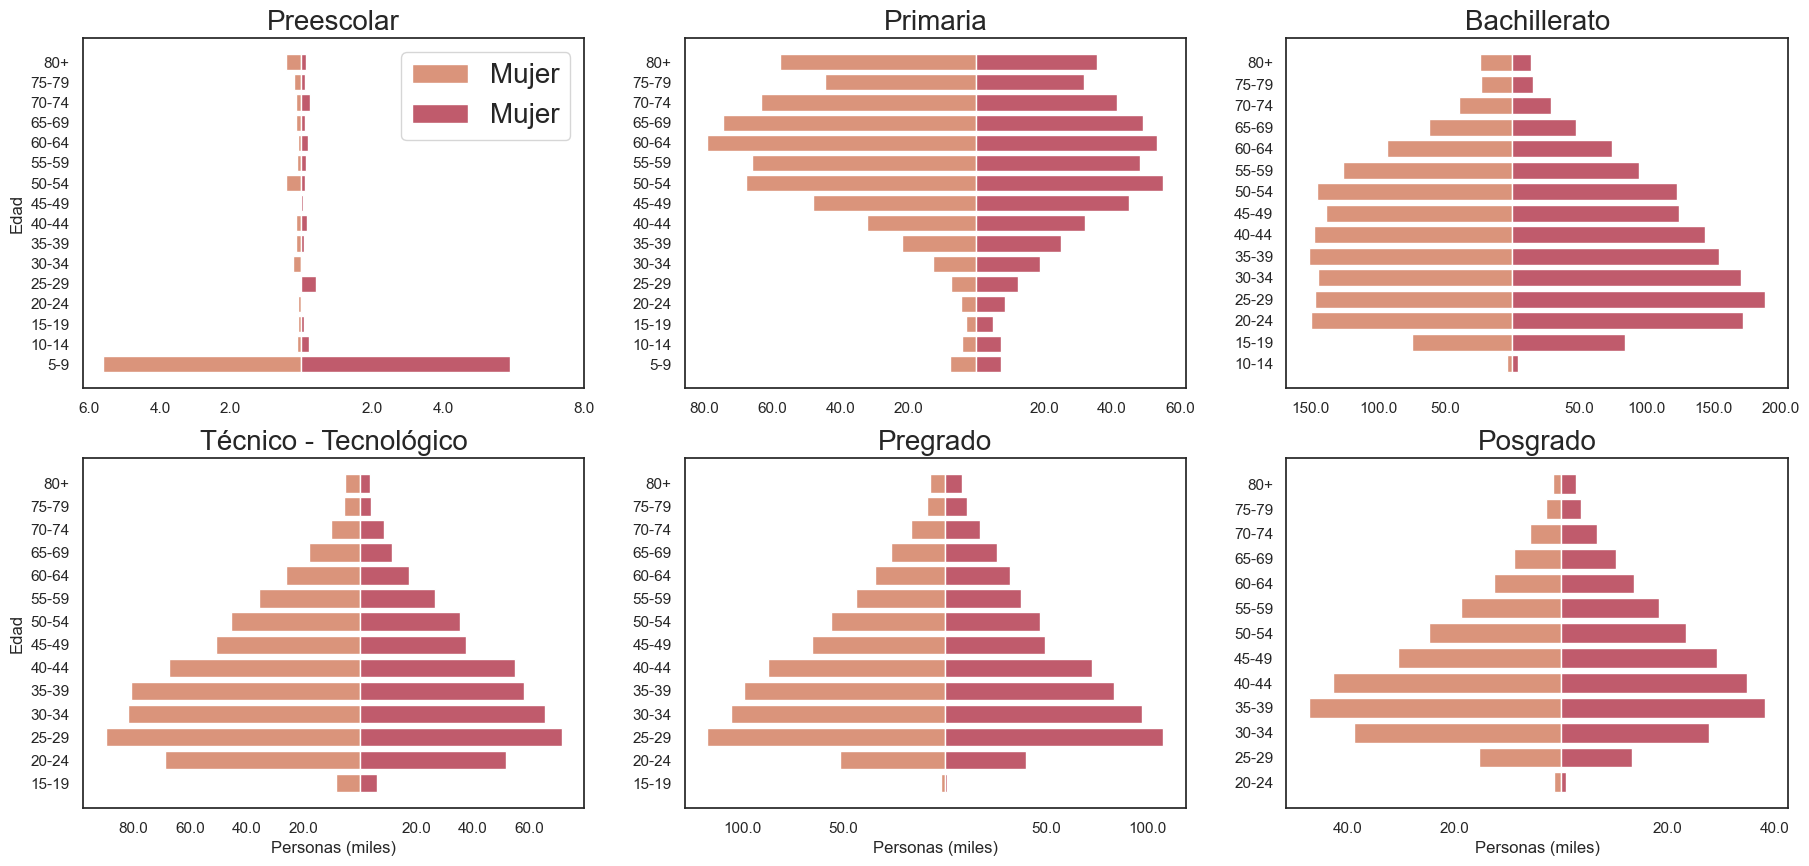

In [433]:
tam={'Preescolar':[-6000,-4000,-2000,0,2000,4000,8000],'Primaria':[-80000,-60000,-40000,-20000,0,20000,40000,60000],
     'Bachillerato':[-150000,-100000,-50000,0,50000,100000,150000,200000],'Técnico - Tecnológico':[-80000,-60000,-40000,-20000,0,20000,40000,60000],
     'Pregrado':[-100000,-50000,0,50000,100000],'Posgrado':[-40000,-20000,0,20000,40000]}
plt.figure(figsize=(22,10))
grados1=multi.ultimo_grado.value_counts().keys().tolist()
cc=1
for i in ['Preescolar','Primaria','Bachillerato','Técnico - Tecnológico','Pregrado','Posgrado']:
    logro=multi[multi['ultimo_grado']==i]
    tabla=pd.crosstab(logro.edad,logro.SEXO,aggfunc='sum',values=logro.FEX_C).round()
    tabla['orden']=[etiq[x] for x in tabla.index]
    tabla.sort_values('orden',inplace=True)
    ypos=tabla.index
    plt.subplot(2,3,cc)
    plt.barh(ypos,-tabla['Mujer'],align='center',label='Mujer',color='#DA947B')
    plt.barh(ypos,tabla['Hombre'],align='center',label='Mujer',color='#C05B6C')
    if cc==1:plt.legend(fontsize=20)
    plt.title(i,fontsize=20)
    lab={}
    for x in tam[i]:
        if x<0:lab[x]=(-x/1000)
        elif x==0: lab[x]=''
        else: lab[x]=x/1000
    plt.xticks(tam[i],labels=[lab[x] for x in tam[i]])
    if cc>3:plt.xlabel('Personas (miles)')
    if cc in [1,4]:plt.ylabel('Edad')
    cc+=1
   
    

No tienen último grado

In [434]:
multi.ultimo_grado.unique()

array(['Posgrado', nan, 'Bachillerato', 'Pregrado',
       'Técnico - Tecnológico', 'Primaria', 'Ninguno', 'Preescolar'],
      dtype=object)

Text(0, 0.5, 'Edad')

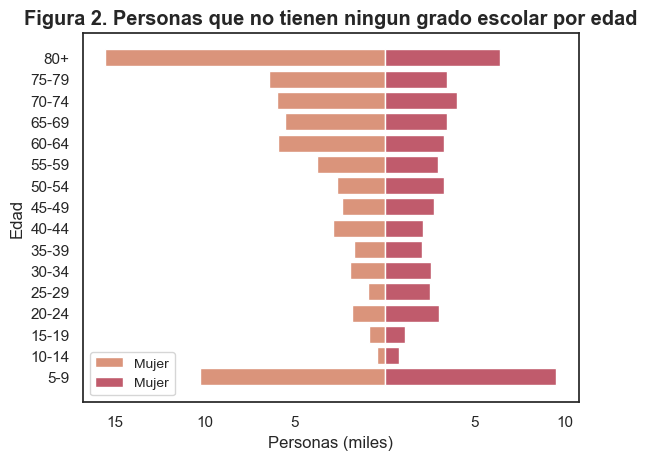

In [435]:
logro=multi[multi['ultimo_grado']=='Ninguno']
tabla=pd.crosstab(logro.edad,logro.SEXO,aggfunc='sum',values=logro.FEX_C).round()
tabla['orden']=[etiq[x] for x in tabla.index]
tabla.sort_values('orden',inplace=True)
ypos=tabla.index
plt.barh(ypos,-tabla['Mujer'],align='center',label='Mujer',color='#DA947B')
plt.barh(ypos,tabla['Hombre'],align='center',label='Mujer',color='#C05B6C')
plt.legend(fontsize=10)
plt.title('Figura 2. Personas que no tienen ningun grado escolar por edad',weight= 'bold',size='large')
plt.xticks([-15000,-10000,-5000,0,5000,10000],[15,10,5,'',5,10])
plt.xlabel('Personas (miles)')
plt.ylabel('Edad')


**3. Nivel acádemico alcanzado por padres**

In [436]:
grado={1:'Ninguno',2: 'Preescolar',3: 'Primaria',4: 'Media',5: 'Bachillerato',6: 'Técnico',7: 'Técnico',
8: 'Pregrado',9: 'Pregrado',10: 'Especialización',11: 'Especialización',12: 'Maestría',13: 'Maestría',14: 'Doctorado',15: 'Doctorado'}

In [437]:
multi['grado_persona']=multi['NPCHP4'].replace(grado)

In [438]:
ord={}
m=1
for i in grado.values():
    ord[i]=m
    m+=1

Logro de los papas

In [439]:
grado_p={1: 'Primaria',2: 'Secundaria',3: 'Media',4: 'Técnico',5: 'Tecnológico',
6: 'Universitario',7: 'Especialización',8: 'Maestría',9: 'Doctorado',10:'Ninguno',99: 'No sabe'}

In [440]:
multi['grado_padre']=multi['NPCEP22'].replace(grado_p)
multi['grado_madre']=multi['NPCEP25'].replace(grado_p)

In [441]:
madre=pd.crosstab(multi.grado_persona,multi.grado_madre,aggfunc='sum',values=multi.FEX_C)[grado_p.values()].fillna(0).round().iloc[:,:-1].pipe(lambda x: round(100*x.div(x.sum()),2))
madre['orden']=[ord[i] for i in madre.index]
madre.sort_values('orden',inplace=True)
madre.drop(columns='orden',inplace=True)


In [442]:
padre=pd.crosstab(multi.grado_persona,multi.grado_padre,aggfunc='sum',values=multi.FEX_C)[grado_p.values()].fillna(0).round().iloc[:,:-1].pipe(lambda x: round(100*x.div(x.sum()),2))
padre['orden']=[ord[i] for i in padre.index]
padre.sort_values('orden',inplace=True)
padre.drop(columns='orden',inplace=True)

Gráfica: probabilidad condicional a la educación de los padres

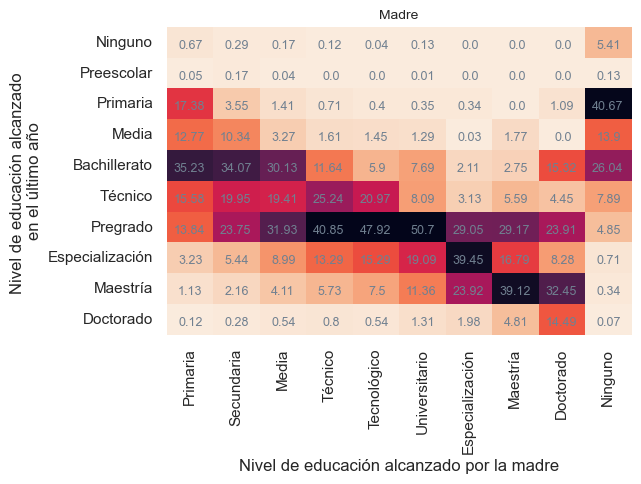

In [446]:
plt.figure(figsize=(6,4))
T=9
sns.heatmap(madre,cmap='rocket_r',robust=True ,cbar_kws={'label':'Porcentaje'},cbar=False)
plt.xlabel('Nivel de educación alcanzado por la madre')
plt.ylabel('Nivel de educación alcanzado \nen el último año')
plt.title('Madre',fontsize=10)
for i in range(madre.shape[0]):
    for j in range(madre.shape[1]):
        if len(str(madre.iloc[i,j]))==3:
            plt.text(x=j+0.35,y=i+0.7,s=str(madre.iloc[i,j]),color='slategray',size=T)
        elif len(str(madre.iloc[i,j]))==4:
            plt.text(x=j+0.25,y=i+0.7,s=str(madre.iloc[i,j]),color='slategray',size=T)
        else: plt.text(x=j+0.15,y=i+0.7,s=str(madre.iloc[i,j]),color='slategray',size=T)





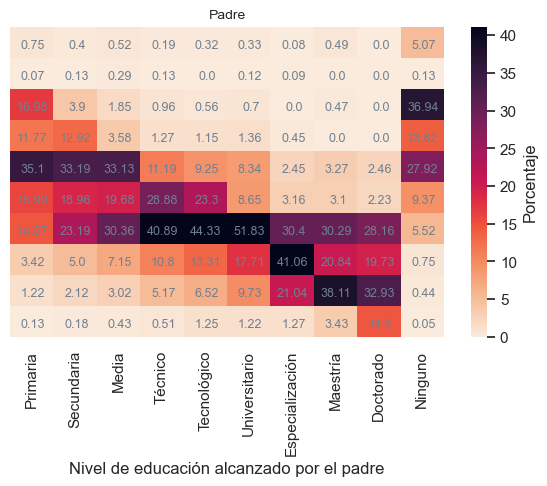

In [447]:
plt.figure(figsize=(7,4.03))
sns.heatmap(padre,cmap='rocket_r',robust=True ,cbar_kws={'label':'Porcentaje'},yticklabels=False)
plt.xlabel('Nivel de educación alcanzado por el padre')
plt.ylabel('Nivel de educación alcanzado \nen el último año').set_visible(False)
plt.title('Padre',fontsize=10)
# plt.title('Figura 3. Probabilidad de alcanzar un nivel educativo dado \nel nivel alcanzado por sus padres',weight= 'bold',size='large')
for i in range(padre.shape[0]):
    for j in range(padre.shape[1]):
        if len(str(padre.iloc[i,j]))==3:
            plt.text(x=j+0.35,y=i+0.7,s=str(padre.iloc[i,j]),color='slategray',size=T)
        elif len(str(padre.iloc[i,j]))==4:
            plt.text(x=j+0.25,y=i+0.7,s=str(padre.iloc[i,j]),color='slategray',size=T)
        else: plt.text(x=j+0.15,y=i+0.7,s=str(padre.iloc[i,j]),color='slategray',size=T)

**4. Jovenes menor o igual a 18 años**

In [448]:
joven=multi[multi['NPCEP4']<19]

In [449]:
print(f"El {round((joven[joven['NPCHP2']==2].FEX_C.sum()/joven.FEX_C.sum())*100,1)}% de los niños, niñas, adolecentes y jovenes que tienen 18 años o menos no están estudiando")

El 7.4% de los niños, niñas, adolecentes y jovenes que tienen 18 años o menos no están estudiando


In [450]:
grado_act={1:'Preescolar',2: 'Primaria',3: 'Secundaria',4: 'Media',5: 'Técnico',6: 'Tecnológico',
7: 'Universitario',8: 'Especialización',8: 'Maestría',10: 'Doctorado'}

Text(0.5, 1.0, 'Figura 4. Proporción de personas que están en un \nnivel académico segun su edad')

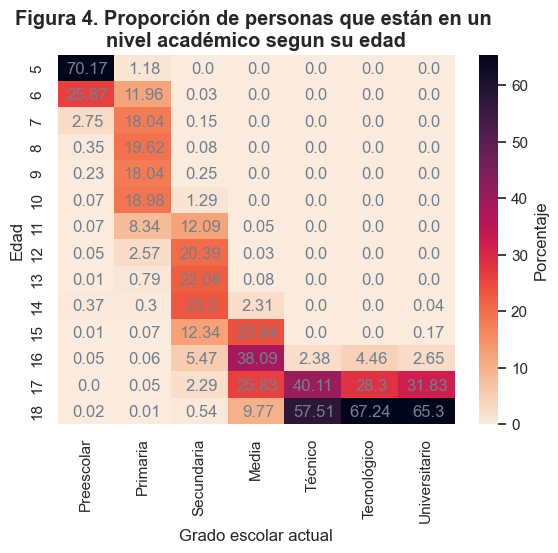

In [457]:
grado_C=pd.crosstab(joven.NPCEP4,joven.NPCHP6,aggfunc='sum',values=joven.FEX_C).fillna(0).round().pipe(lambda x: round(100*x.div(x.sum()),2))
sns.heatmap(grado_C,cmap='rocket_r',robust=True ,cbar_kws={'label':'Porcentaje'})
for i in range(grado_C.shape[0]):
    for j in range(grado_C.shape[1]):
        if len(str(grado_C.iloc[i,j]))==3:
            plt.text(x=j+0.35,y=i+0.7,s=str(grado_C.iloc[i,j]),color='slategray')
        elif len(str(grado_C.iloc[i,j]))==4:
            plt.text(x=j+0.25,y=i+0.7,s=str(grado_C.iloc[i,j]),color='slategray')
        else: plt.text(x=j+0.15,y=i+0.7,s=str(grado_C.iloc[i,j]),color='slategray')
plt.xticks([i-0.5 for i in  grado_C.columns],[grado_act[int(i)] for i in grado_C.columns],rotation=90)
plt.ylabel('Edad')
plt.xlabel('Grado escolar actual')
plt.title('Figura 4. Proporción de personas que están en un \nnivel académico segun su edad',weight= 'bold',size='large')


jovenes en rezago

In [459]:
colegio={1:6,2:7,3:8,4:9,5:10,6:11,7:12,8:13,9:14,10:15,11:16,12:17,13:18}
superior={1:17,2:18,3:19,4:20}
preescolar=5

edad_grado=[]
for i in range(joven.shape[0]):
    if joven.NPCHP6.tolist()[i]==1:
        edad_grado.append(preescolar)
    elif joven.NPCHP6.tolist()[i]>4:
        edad_grado.append(superior[int(joven.NPCHP6A.tolist()[i])])
    elif joven.NPCHP6.isna().tolist()[i]==True:
        edad_grado.append(np.NaN)
    else:
        edad_grado.append(colegio[int(joven.NPCHP6A.tolist()[i])])
joven['edad_grado']=edad_grado

In [460]:
joven['rezago_a']=(joven.edad_grado-joven.NPCEP4)

Text(0.5, 1.0, 'Figura 5. Rezago escolar en años')

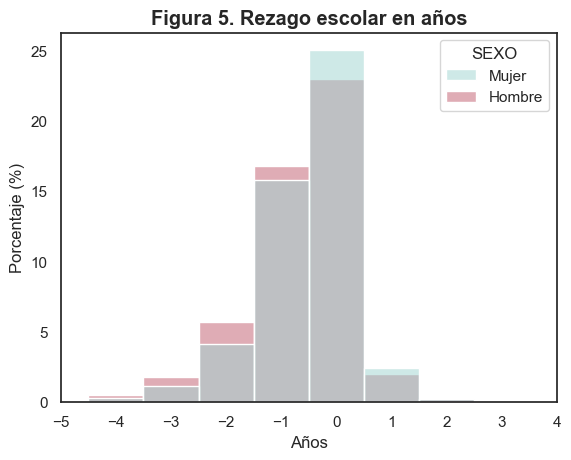

In [470]:
sns.histplot(data=joven,x='rezago_a',hue='SEXO',stat="percent", discrete=True,palette=['#9fd5d1','#C05B6C'])
plt.xlim(-5,4)
plt.ylabel('Porcentaje (%)')
plt.xlabel('Años')
plt.title('Figura 5. Rezago escolar en años',weight= 'bold',size='large')


**5. Pesonas de mayor edad**

In [50]:
mayor=multi[multi['NPCEP4']>=18]

In [51]:
or_gr={'Ninguno':0,'Preescolar':1, 'Primaria':2, 'Bachillerato':3,'Técnico - Tecnológico':4, 'Pregrado':5,'Posgrado':6}
mayor['ultimo_grado']=mayor['ultimo_grado'].replace(or_gr)

In [52]:
grado_a={2: 0,3:0,4:5,5:9,6:11,7: 11,8: 11,9: 11,10: 17,11: 17,12: 17,13: 17,14: 19,14: 15,1:0}
mayor['años_est']=mayor.NPCHP4.replace(grado_a)
mayor['años_persona']=mayor.NPCHP4A+mayor['años_est']
mayor['años_persona'].fillna(0,inplace=True)

In [53]:
grado_a={1: 0,2: 5,3: 9,4:11,5: 11,6: 11,7: 17,8: 17,9: 19,10:0,99:-1}
mayor['años_papa']=mayor.NPCEP22.replace(grado_a)
mayor['años_mama']=mayor.NPCEP25.replace(grado_a)

    
mayor['educ_papa']=mayor.NPCEP22A+mayor.años_papa
mayor['educ_mama']=mayor.NPCEP25A+mayor.años_papa

Indice de servicios

In [54]:
mayor['sevicios']=mayor[['NVCBP11A','NVCBP11B','NVCBP11C','NVCBP11D']].replace(2,0).sum(axis=1)*.25

Reescribir el género

In [55]:
mayor.SEXO.replace({'Hombre':0,'Mujer':1},inplace=True)

Si se translado de ciudad

In [56]:
mayor['translado']=mayor['NPCEP11'].replace({1:0,2:1,3:1})

Si tiene casa propia

In [57]:
mayor['propia']=[1 if i in [1,2] else 0 for i in mayor['NHCCP1']]

Área donde viven

In [59]:
mayor['area']=mayor.CLASE.replace({2:1,3:0})

Total de ingresos

In [61]:
mayor['ingreso']=mayor[['W','Y','Pensiones']].sum(axis=1)

In [270]:
a=pd.get_dummies(mayor['SEXO'],dtype='int')
a.columns=['Hombre','Mujer']

for i in a.columns:
    mayor[i]=a[i]


Variables a tener en cuenta

In [320]:
mayor_=mayor[['ultimo_grado','años_persona','NPCEP4','Hombre','Mujer','educ_papa','educ_mama','propia','NHCCPCTRL2','sevicios','ingreso','Cuidado','Experiencia','Subsidios','Valor_matricula',
 'Varlor_beca','OINFORMAL','area','NPCKP1']]

Datos faltantes

In [321]:
mayor_['nan']=mayor_.ultimo_grado.isna()
id=mayor_[mayor_['nan']==True].index.tolist()

Eliminan las filas cuya personas no tienen registrada su último logro académico, debido a que es una muestra aleatorea no genera riesgos de sesgo.

In [322]:
mayor_s=mayor_.drop(index=id)
mayor_s.drop(columns='nan',inplace=True)

Se remplazan los datos faltantes con 0 suponiendo que estas personas no tienen un salario, un ingreso, una pensión, no cuidan no tiene experiencia,no son informales, no tienen un crédito.

In [323]:
for i in ['ingreso','Cuidado','Experiencia','OINFORMAL']:
    mayor_s[i]=mayor_s[i].fillna(0)

Crea una variable dummy por cada actividad que se este realizando

In [324]:
a=pd.get_dummies(mayor_s['NPCKP1'],dtype='int')
a.columns=['Trabajando', 'Buscando_trabajo', 'Estudiando', 'Oficios_hogar','Incapacitado', 'Otra actividad']
for i in a.columns:
    mayor_s[i]=a[i]
mayor_s.drop(columns='NPCKP1',inplace=True)

Se remplazan datos faltantes con la mediana de los datos

In [325]:
from sklearn.impute import KNNImputer,SimpleImputer

In [326]:
perdidos=SimpleImputer(strategy='median')
for i in ['educ_papa','educ_mama']:
    mayor_s[i]=perdidos.fit_transform(mayor_s[i].to_numpy().reshape(-1,1))

## Regresión logistica

In [327]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import statsmodels.api as sm
import statsmodels
import statsmodels.formula.api as smf
from statsmodels.stats.weightstats import ttest_ind
from sklearn.preprocessing import StandardScaler


Modelo con todas las variables

In [328]:
y=mayor_s.ultimo_grado.to_numpy()
X=mayor_s.iloc[:,1:].to_numpy()

Normalizamos los datos independientes

In [329]:
stand=StandardScaler()
X=stand.fit_transform(X)

In [330]:
X_train, X_test, y_train, y_test = train_test_split(X,y.reshape(-1,1),train_size=0.8,random_state=1995)

Un primer modelo para determina el accuaracy y si las variables son correctas

In [331]:
modelo = LogisticRegression(multi_class="multinomial",solver="lbfgs", C=50)
modelo.fit(X = X_train, y = y_train)

LogisticRegression(C=50, multi_class='multinomial')

In [332]:
print("Accuracy de entrenamiento:", modelo.score(X, y))

Accuracy de entrenamiento: 0.7417800453514739


In [333]:
print(f'Accuracy de la predicción: {accuracy_score(y_test,modelo.predict(X_test))}')

Accuracy de la predicción: 0.7430520525569888


El accuracy no es tan bajo para decir que esta subestimando (underfitting)

In [334]:
pd.DataFrame(modelo.coef_,columns=mayor_s.columns[1:]).sum()

años_persona       -1.634248e-13
NPCEP4              1.221245e-14
Hombre              9.436896e-16
Mujer              -9.436896e-16
educ_papa          -1.953993e-14
educ_mama          -1.110223e-14
propia             -1.665335e-15
NHCCPCTRL2         -1.199041e-14
sevicios            2.337019e-14
ingreso             9.525714e-14
Cuidado            -1.912359e-14
Experiencia         1.564027e-14
Subsidios           0.000000e+00
Valor_matricula     0.000000e+00
Varlor_beca         0.000000e+00
OINFORMAL          -3.386180e-15
area                2.594105e-14
Trabajando         -1.938727e-14
Buscando_trabajo   -2.459144e-14
Estudiando         -1.154632e-14
Oficios_hogar       4.574119e-14
Incapacitado       -1.665335e-14
Otra actividad     -1.584843e-14
dtype: float64

De estos caedicientes se puede ver que el valor de la matricula, el valor de la beca ni los subsidios tienen un efecto en la probabilidad de alcanzar un grado, por ende se pueden obviar del modelo.

In [337]:
mayor_s=mayor_s[['ultimo_grado', 'años_persona', 'NPCEP4', 'Hombre','Mujer','educ_papa', 'educ_mama', 'propia', 'NHCCPCTRL2', 'sevicios', 'ingreso',
       'Cuidado', 'Experiencia', 'OINFORMAL', 'area', 'Trabajando', 'Buscando_trabajo', 'Estudiando','Oficios_hogar', 'Incapacitado', 'Otra actividad']]

In [338]:
y=mayor_s.ultimo_grado.to_numpy()
X=mayor_s.iloc[:,1:].to_numpy()

### Se normaliza

stand=StandardScaler()
X=stand.fit_transform(X)

## Se divide entre entrenamiento y testeo

X_train, X_test, y_train, y_test = train_test_split(X,y.reshape(-1,1),train_size=0.8,random_state=1995)

Un segundo modelo

In [339]:
modelo1 = LogisticRegression(multi_class="multinomial",solver="lbfgs", C=10)
modelo1.fit(X = X_train, y = y_train)

LogisticRegression(C=10, multi_class='multinomial')

In [340]:
print("Accuracy de entrenamiento:", modelo1.score(X, y))

Accuracy de entrenamiento: 0.7417704369883547


In [341]:
print(f'Accuracy de la predicción: {accuracy_score(y_test,modelo1.predict(X_test))}')

Accuracy de la predicción: 0.7430760731185895


El accuracy no no cambio desde el modelo anterior por lo tanto quitar las variables no vario el modelo. Efectos total del modelo:

In [342]:
pd.DataFrame(modelo1.coef_,columns=mayor_s.columns[1:]).sum()

años_persona       -3.836931e-13
NPCEP4              4.429790e-14
Hombre              3.927414e-15
Mujer              -3.927414e-15
educ_papa           1.376677e-14
educ_mama          -4.440892e-16
propia             -3.441691e-14
NHCCPCTRL2         -7.271961e-15
sevicios            3.762962e-14
ingreso            -4.540812e-14
Cuidado            -9.714451e-15
Experiencia        -1.099121e-14
OINFORMAL          -3.030909e-14
area                1.124101e-14
Trabajando         -1.942890e-15
Buscando_trabajo   -1.201816e-14
Estudiando         -1.942890e-14
Oficios_hogar       1.021405e-14
Incapacitado       -2.770006e-14
Otra actividad     -1.770806e-14
dtype: float64

Todas las variables tienen un efecto sobre la probabilidad de alcanzar un grado.

In [343]:
efectos=pd.DataFrame(modelo1.coef_,columns=mayor_s.columns[1:]).apply(lambda x: np.exp(x))

In [344]:
grado={0:'Ninguno',1: 'Preescolar',2: 'Primaria',3: 'Bachillerato',3: 'Bachillerato',4: 'Técnico\n Tecnológico',5: 'Pregrado',6: 'Posgrado'}

Text(0.5, 1.0, 'Efecto de su género')

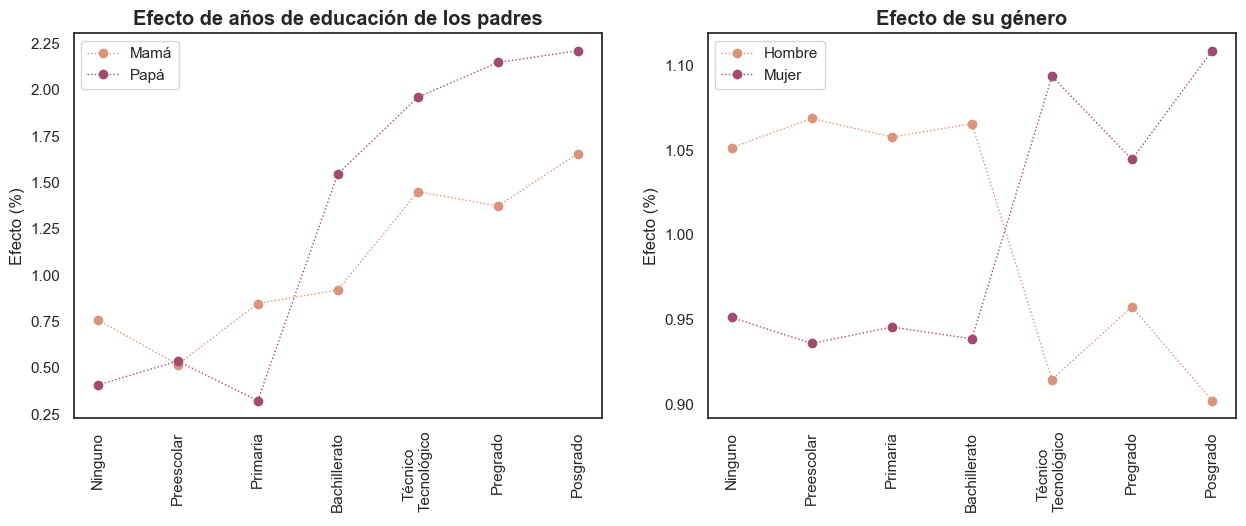

In [361]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(efectos.educ_mama,marker='.',linestyle=':',lw=1,mew=4,label='Mamá',color='#DA947B')
plt.plot(efectos.educ_papa,marker='.',linestyle=':',lw=1,mew=4,label='Papá',color='#A24A6F')
plt.xticks([0,1,2,3,4,5,6],[grado[i] for i in [0,1,2,3,4,5,6]],rotation=90)
plt.legend()
plt.ylabel('Efecto (%)')
plt.title('Efecto de años de educación de los padres',weight= 'bold',size='large')

plt.subplot(1,2,2)
plt.plot(efectos.Hombre,marker='.',linestyle=':',lw=1,mew=4,label='Hombre',color='#DA947B')
plt.plot(efectos.Mujer,marker='.',linestyle=':',lw=1,mew=4,label='Mujer',color='#A24A6F')
plt.xticks([0,1,2,3,4,5,6],[grado[i] for i in [0,1,2,3,4,5,6]],rotation=90)
plt.legend()
plt.ylabel('Efecto (%)')
plt.title('Efecto de su género',weight= 'bold',size='large')

Text(0.5, 1.0, 'Efecto de la actividad actual')

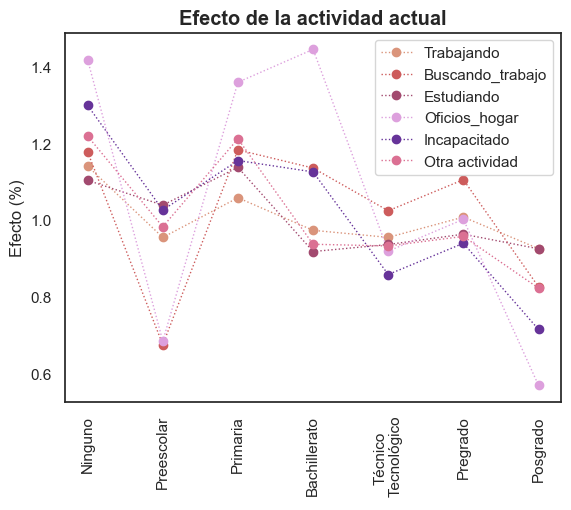

In [347]:
color=['#DA947B','indianred','#A24A6F','plum','rebeccapurple','palevioletred','crimson']
n=0
for i in efectos.columns[-6:]:
    plt.plot(efectos[i],marker='.',linestyle=':',lw=1,mew=4,label=i,color=color[n])
    n+=1
plt.xticks([0,1,2,3,4,5,6],[grado[i] for i in [0,1,2,3,4,5,6]],rotation=90)
plt.legend()
plt.ylabel('Efecto (%)')
plt.title('Efecto de la actividad actual',weight= 'bold',size='large')

Text(0.5, 1.0, 'Efecto del trabajo y cuidado')

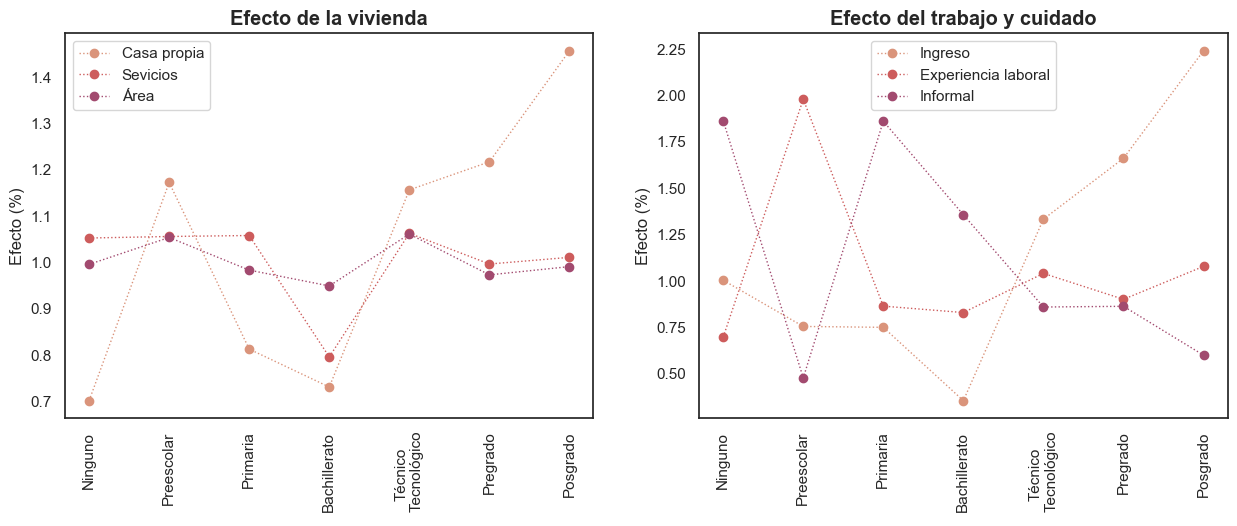

In [367]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
n=0
for i in [ 'propia', 'sevicios' , 'area']:
    plt.plot(efectos[i],marker='.',linestyle=':',lw=1,mew=4,color=color[n])
    n+=1
plt.xticks([0,1,2,3,4,5,6],[grado[i] for i in [0,1,2,3,4,5,6]],rotation=90)
plt.legend(['Casa propia', 'Sevicios' , 'Área'])
plt.ylabel('Efecto (%)')
plt.title('Efecto de la vivienda',weight= 'bold',size='large')

plt.subplot(1,2,2)
n=0
for i in [ 'ingreso', 'Experiencia','OINFORMAL']:
    plt.plot(efectos[i],marker='.',linestyle=':',lw=1,mew=4,color=color[n])
    n+=1
plt.xticks([0,1,2,3,4,5,6],[grado[i] for i in [0,1,2,3,4,5,6]],rotation=90)
plt.legend(['Ingreso', 'Experiencia laboral','Informal'])
plt.ylabel('Efecto (%)')
plt.title('Efecto del trabajo y cuidado',weight= 'bold',size='large')

In [365]:
efectos.mean()

años_persona        2.149382e+06
NPCEP4              1.266025e+00
Hombre              1.002441e+00
Mujer               1.002491e+00
educ_papa           1.303106e+00
educ_mama           1.073543e+00
propia              1.035199e+00
NHCCPCTRL2          1.014049e+00
sevicios            1.004375e+00
ingreso             1.156821e+00
Cuidado             1.010560e+00
Experiencia         1.055693e+00
OINFORMAL           1.125898e+00
area                1.000728e+00
Trabajando          1.002297e+00
Buscando_trabajo    1.018299e+00
Estudiando          1.003389e+00
Oficios_hogar       1.056825e+00
Incapacitado        1.017072e+00
Otra actividad      1.009151e+00
dtype: float64